In [136]:
'''Restricted Bolzmann machine'''
'''Currently not working'''

import numpy as np

class RBM():
    
    def __init__(self,n_visible,n_hidden):
        self.weights = np.random.normal(0,0.1,(n_hidden,n_visible))
        self.bias_h = np.random.normal(0,0.1,(n_hidden))
        self.bias_v = np.random.normal(0,0.1,(n_visible))  
        
    def sample_h(self,X,return_probabilities=False):
        z = X @ self.weights.T + self.bias_h # shape of result: samples x n_hidden
        prob = sigmoid(z)
        if (return_probabilities):
            return prob
        else:
            return bernoulli(prob) 

    def sample_v(self,X,return_probabilities=False):
        z = X @ self.weights + self.bias_v # shape of result: samples x n_visible
        prob = sigmoid(z)
        if (return_probabilities):
            return prob
        else:
            return bernoulli(prob) 
    
    def train(self,x0,xk,ph0,phk):
        ii,jj = self.weights.shape
        for i in range(ii):
            for j in range(jj):
                self.weights[i,j] += ( x0[:,j].T @ ph0[:,i] ) - ( xk[:,j].T @ phk[:,i] )
        #self.weights += x0.T @ ph0 - xk.T @ phk
        self.bias_v += (x0 - xk).sum(axis=0)
        self.bias_h += (ph0 - phk).sum(axis=0)
        
def sigmoid(X):
    return 1/(np.exp(-X)+1)    

def bernoulli(X):
    draws = np.random.random(X.shape)
    return (X > draws).astype(int)

In [274]:
# data

X = np.random.random((1000,2))-0.5
y = X[:,0]**2 + X[:,1]**2 < 0.16

X = np.hstack((X,y[:,None]))

In [275]:
import matplotlib.pyplot as plt

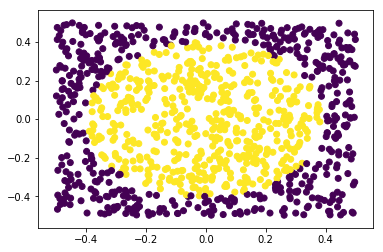

In [276]:
plt.scatter(X[:,0],X[:,1],c=X[:,2])
plt.show()

In [293]:
rbm = RBM(3,12)

epochs = 1000
k = 10
batch_size = 10

for epoch in range(epochs):
    ind = 0
    for batch in range(len(X)//batch_size+1):
        x0 = X[ind:ind+batch_size]
        ind+=batch_size
        if (len(x0)==0):
            break
        ph0 = rbm.sample_h(x0,True)
        # xk when k=0
        xk = x0
        for i in range(k):
            # feed into the machine
            hk = rbm.sample_h(xk)
            xk = rbm.sample_v(hk)
        phk = rbm.sample_h(xk,True)
        rbm.train(x0,xk,ph0,phk)

In [294]:
(rbm.sample_v(rbm.sample_h(X))[:,2] == X[:,2]).mean()

0.475